## Hyperspectral Image Testing

In [3]:
import spectral
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import shutil

In [4]:
# Replace the Header file path and Image file path to actual paths
header_file = r"D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17.hdr"
bil_image_file = r"D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17.bil"
print(os.getcwd())

D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data_processing\Hyp_preprocess_calib


In [6]:
# Load the ENVI dataset
image = spectral.open_image(header_file)

# Access specific bands
band_number = 11  # Change this to the desired band number
band_data = image[:, :, band_number]

# Access all bands
all_bands_data = image.load()

print(f"Band {band_number} data shape: {band_data.shape}")
print(f"All bands data shape: {all_bands_data.shape}")

Band 11 data shape: (2127, 640, 1)
All bands data shape: (2127, 640, 224)


(2127, 640, 1)


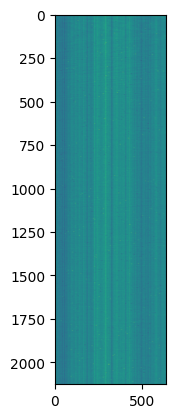

In [7]:
band_np = np.array(band_data)
print(band_np.shape)
plt.imshow(band_np) #band_11

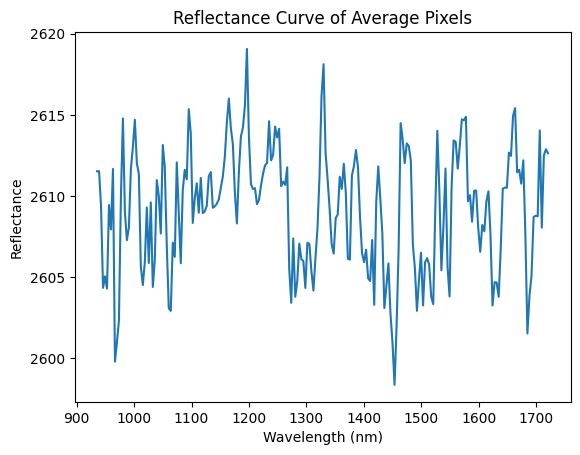

In [8]:
# Plot Reflectance Curve ( Wavelengths vs Mean Pixel Values of Image ) 
image_data = image.load()
mean_values = np.mean(image_data, axis=(0, 1))
wavelengths = [float(wavelength) for wavelength in image.metadata['wavelength']]

plt.plot(wavelengths, mean_values)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance Curve of Average Pixels')
# plt.grid(True)
plt.show()

In [9]:
from skimage.io import imsave

def find_nearest_band(wavelengths, target_wavelength):
    wavelengths_float = np.array([float(w) for w in wavelengths])
    return np.argmin(np.abs(wavelengths_float - target_wavelength))

In [10]:
def get_hyp_rgb(image, wavelengths, save_path):
    """
    Generate and save a false-color RGB image from a hyperspectral cube.

    This function extracts three spectral bands (near 950 nm, 970 nm, and 990 nm)
    from a hyperspectral image and combines them to form a false-color RGB
    visualization. The resulting image is normalized to [0, 1], scaled to [0, 255],
    saved as a PNG file, and displayed using matplotlib.

    Parameters:
    image : spectral.Image or numpy.ndarray
        The hyperspectral image cube. Can be a Spectral library image object 
        (with a `.load()` method) or a 3D NumPy array of shape (height, width, bands).
    
    wavelengths : list or numpy.ndarray
        The list of wavelength values (in nanometers) corresponding to each spectral band.
        Used to identify the nearest bands for red, green, and blue visualization.

    save_path : str
        Path and base filename (typically the .hdr file path) where the generated
        RGB image will be saved. The output is stored as a `.png` file.

    Returns:
    file_path : str
        The full path to the saved PNG file.

    Notes:
    - The spectral range of the Specim FX17 camera (~935–1001 nm) is outside the visible
      spectrum. Therefore, the output is a *false-color* image, not a true-color visualization.
    - The function automatically selects three bands near 950 nm (blue), 970 nm (green),
      and 990 nm (red) for visualization.
    - If the input image is not loaded, it will be converted to a NumPy array automatically.
    
    Example:
    >>> image = spectral.open_image("sample_fx17.hdr")
    >>> wavelengths = image.metadata['wavelength']
    >>> get_hyp_rgb(image, wavelengths, "sample_fx17")
    Image saved as sample_fx17.png
    """

    # If it's a spectral image, load it
    if hasattr(image, "load"):
        image = image.load() # Convert to numpy array
    
    red_band_index = find_nearest_band(wavelengths, 660)
    green_band_index = find_nearest_band(wavelengths, 550)
    blue_band_index = find_nearest_band(wavelengths, 450)

    # Spectral Camera Range is 935 - 1001 
    red_band_index = find_nearest_band(wavelengths, 990)
    green_band_index = find_nearest_band(wavelengths, 970)
    blue_band_index = find_nearest_band(wavelengths, 950)


    # Extract the RGB bands
    red_band = image[:, :, [red_band_index]]
    green_band = image[:, :, [green_band_index]]
    blue_band = image[:, :, [blue_band_index]]

    print(wavelengths[:20])
    print("Shape:", image.shape)
    print("Red:", red_band_index, "Green:", green_band_index, "Blue:", blue_band_index)
    print("Red range:", red_band.min(), red_band.max())
    print("Green range:", green_band.min(), green_band.max())
    print("Blue range:", blue_band.min(), blue_band.max())

    # Normalize the bands to the range [0, 1]
    red_normalized = (red_band - red_band.min()) / (red_band.max() - red_band.min())
    green_normalized = (green_band - green_band.min()) / (green_band.max() - green_band.min())
    blue_normalized = (blue_band - blue_band.min()) / (blue_band.max() - blue_band.min())
    
    # Stack the normalized bands to create an RGB image
    rgb_image = np.stack((red_normalized, green_normalized, blue_normalized), axis=-1)

    # Squeeze any extra dimensions
    rgb_image_squeezed = np.squeeze(rgb_image)

    # Convert the RGB image to the range [0, 255] and save it as a PNG file
    rgb_image_uint8 = (rgb_image_squeezed * 255).astype(np.uint8)
    rgb_image_uint8 = cv2.cvtColor(rgb_image_uint8, cv2.COLOR_RGB2BGR)
    
    file_path = save_path[:-4] + ".png"
    try:
        output_path =save_path[:-4]+".png"
        cv2.imwrite(output_path, rgb_image_uint8)
        print(f"Image saved as {output_path}")
    except Exception as e:
        print("Error saving the image:", e)

    # Display the RGB image
    import matplotlib.pyplot as plt

    plt.imshow(rgb_image_squeezed)
    plt.show()
    return file_path

['935.61', '939.06', '942.52', '945.98', '949.43', '952.89', '956.35', '959.81', '963.27', '966.73', '970.19', '973.65', '977.11', '980.58', '984.04', '987.51', '990.97', '994.43', '997.90', '1001.37']
Shape: (2127, 640, 224)
Red: 16 Green: 10 Blue: 4
Red range: 2224.0 2992.0
Green range: 2304.0 2944.0
Blue range: 2336.0 2928.0
Image saved as D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17.png


C:\Users\sasan\AppData\Local\Temp\ipykernel_8164\416688255.py:68: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  red_normalized = (red_band - red_band.min()) / (red_band.max() - red_band.min())
C:\Users\sasan\AppData\Local\Temp\ipykernel_8164\416688255.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  green_normalized = (green_band - green_band.min()) / (green_band.max() - green_band.min())
C:\Users\sasan\AppData\Local\Temp\ipykernel_8164\416688255.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  blue_normalized = (blue_band - blue_band.min()) / (blue_band.max() - blue_band.min())


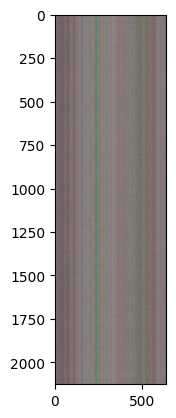

In [11]:
image = spectral.open_image(header_file)
wavelengths = image.metadata['wavelength']
hyp_rgb_image_file = get_hyp_rgb(image, wavelengths, header_file)

In [12]:
def select_coor(img, img_path, save_name):
    """
    Allows the user to interactively select rectangular regions (ROIs) on an image
    using mouse clicks, and saves both the selected region coordinates and the
    extracted region image.

    Parameters:
        img (numpy.ndarray): 
            The image array (typically an RGB visualization of a hyperspectral image)
            on which the user will draw the ROI rectangles.
        
        img_path (str): 
            Path to the corresponding image file (usually the .bil or .hdr file path),
            used to derive the save path for storing the coordinates.
        
        save_name (str): 
            The name used to save the cropped ROI image and the coordinates file.

    Returns:
        str: The file path where the ROI coordinates are saved as a NumPy (.npy) file.

    Description:
        - Opens a resizable OpenCV window to display the image.
        - Lets the user click and drag to draw rectangles on the image.
        - Each drawn rectangle’s corner coordinates are stored.
        - Saves the selected region as a separate image in './coordinates/'.
        - Saves all the rectangle coordinates as a NumPy array (.npy file).
    """
    
    white_calib_coor = []
    drawing = False
    start_x, start_y = -1, -1
    img_original = img.copy()

    # Function to display the coordinates and draw rectangles
    def click_event(event, x, y, flags, params):
        nonlocal drawing, start_x, start_y, white_calib_coor, img, img_original

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            start_x, start_y = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                img_copy = img.copy()
                cv2.rectangle(img_copy, (start_x, start_y), (x, y), (255, 0, 0), 2)
                cv2.imshow('image', img_copy)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            end_x, end_y = x, y
            cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
            cv2.imshow('image', img)
            print("Start:", start_x, start_y, "End:", end_x, end_y)

            # Store all four coordinates of the selected rectangle
            top_left = (start_x, start_y)
            top_right = (end_x, start_y)
            bottom_left = (start_x, end_y)
            bottom_right = (end_x, end_y)
            white_calib_coor.append([top_left, top_right, bottom_right, bottom_left])

            # Save the selected rectangle as a separate image without the blue lines
            roi = img_original[start_y:end_y, start_x:end_x]
            if not os.path.exists('./coordinates'):
                os.mkdir('./coordinates')
            cv2.imwrite('./coordinates' + save_name+'.png', roi)

    # def update_display(*args):
    #     nonlocal img, img_original
    #     x_offset = cv2.getTrackbarPos('Horizontal', 'image')
    #     y_offset = cv2.getTrackbarPos('Vertical', 'image')
    #     img = img_original[y_offset:y_offset + window_height, x_offset:x_offset + window_width]
    #     cv2.imshow('image', img)

    window_width, window_height = 800, 600
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', window_width, window_height)

    # img_height, img_width, _ = img_original.shape
    # cv2.createTrackbar('Horizontal', 'image', 0, img_width - window_width, update_display)
    # cv2.createTrackbar('Vertical', 'image', 0, img_height - window_height, update_display)

    # Displaying the image
    cv2.imshow('image', img)

    # Setting mouse handler for the image and calling the click_event() function
    cv2.setMouseCallback('image', click_event)

    # Wait for a key to be pressed to exit
    cv2.waitKey(0)

    # Close the window
    cv2.destroyAllWindows()

    print(white_calib_coor)
    # os.makedirs('./data/coordinates_test', exist_ok=True)
    # Derive the save path from the img_path
    save_path = os.path.splitext(img_path)[0]+'_'+save_name + '.npy'
    
    with open(save_path, 'wb') as f:
        np.save(f, white_calib_coor)

    print(f"Coordinates saved to: {save_path}")
    return save_path


In [13]:
# Reading the Hyperspectral Image (.bil image)
image_path = hyp_rgb_image_file
img = cv2.imread(image_path,1)
print(type(img))

<class 'numpy.ndarray'>


In [14]:
# Getting the white calibration data
white_calib_coord_file = select_coor(img,image_path,'white_calib')

Start: 144 610 End: 495 1631
[[(144, 610), (495, 610), (495, 1631), (144, 1631)]]
Coordinates saved to: D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17_white_calib.npy


In [15]:
# Getting the dark calibration data
dark_calib_coord_file = select_coor(img,image_path,'dark_calib')

Start: 208 879 End: 438 1478
[[(208, 879), (438, 879), (438, 1478), (208, 1478)]]
Coordinates saved to: D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17_dark_calib.npy


In [16]:
# Dark Calibration Array
dc = np.load(white_calib_coord_file)
print(dc)

# White Calibration Array
wc = np.load(dark_calib_coord_file)
print(wc)

[[[ 144  610]
  [ 495  610]
  [ 495 1631]
  [ 144 1631]]]
[[[ 208  879]
  [ 438  879]
  [ 438 1478]
  [ 208 1478]]]


In [17]:
# Function to get regions of interest
def get_rois(white_calib_coord_file:str,dark_calib_coord_file:str):
    # Loading the saved dark calibration and white calibration coordinates
    dc = np.load(dark_calib_coord_file)
    wc = np.load(white_calib_coord_file)

    # Constructing the new, larger rectangle
    big_rect = np.array([[
        [wc[0][0][0], wc[0][0][1]],    # Top-left corner
        [wc[0][1][0], wc[0][1][1]],    # Top-right corner
        [wc[0][3][0], dc[0][3][1]],     # Bottom-left corner
        [wc[0][2][0], dc[0][3][1]]    # Bottom-right corner
    ]])
    
    return dc, wc, big_rect

In [18]:
print(header_file)
image = spectral.open_image(header_file)
print(np.shape(image))
dc, wc, big_rect = get_rois(white_calib_coord_file,dark_calib_coord_file)

D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17.hdr
(2127, 640, 224)


In [19]:
# img = cv2.imread(hyp_rgb_image_file, 1)
# cv2.namedWindow('finalImg', cv2.WINDOW_NORMAL)
# cv2.imshow("finalImg",img)
# cv2.waitKey(0)

# # Close the window
# cv2.destroyAllWindows()

In [20]:
# # the array is saved in the file geekfile.npy 
# b = np.load(white_calib_coord_file)
# print(type(b))
# print(b)

In [21]:
def rect_area(b):
    # Compute the length of one side of the rectangle
    side1 = np.linalg.norm(b[0][0] - b[0][1])

    # Compute the length of the other side of the rectangle
    side2 = np.linalg.norm(b[0][1] - b[0][2])

    # Compute the area of the rectangle
    area = side1 * side2
    return area

In [22]:
# Dark Calibration Rectangle Area
dark_cb = np.load(dark_calib_coord_file)
print(dark_cb)
print(rect_area(dark_cb))

[[[ 208  879]
  [ 438  879]
  [ 438 1478]
  [ 208 1478]]]
137770.0


In [23]:
# White Calibration Rectangle Area
white_cb = np.load(white_calib_coord_file)
print(white_cb)
print(rect_area(white_cb))

[[[ 144  610]
  [ 495  610]
  [ 495 1631]
  [ 144 1631]]]
358371.0


In [24]:
# Finding Reflectance using White, Dark and Raw Intensity

# No Data for these

# Calibrating the data
white_hdr_file = 'path/to/your/white_reference.hdr'
dark_hdr_file = 'path/to/your/dark_reference.hdr'
raw_hdr_file = 'path/to/your/raw_data.hdr'

white_data = spectral.open_image(white_hdr_file)
dark_data = spectral.open_image(dark_hdr_file)
raw_data = spectral.open_image(raw_hdr_file)

white_array = np.array(white_data.load())
dark_array = np.array(dark_data.load())
raw_array = np.array(raw_data.load())

# Subtract the dark reference from the raw and white reference data
raw_minus_dark = raw_array - dark_array
white_minus_dark = white_array - dark_array

# Perform element-wise division to calibrate the data
calibrated_data = raw_minus_dark / white_minus_dark

FileNotFoundError: Unable to locate file "path/to/your/white_reference.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.

### Normalised Hyperspectral RGB Image

D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17.hdr


C:\Users\sasan\AppData\Local\Temp\ipykernel_8164\4070102185.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_image_data = (image_data - min_value) / (max_value - min_value)


['935.61', '939.06', '942.52', '945.98', '949.43', '952.89', '956.35', '959.81', '963.27', '966.73', '970.19', '973.65', '977.11', '980.58', '984.04', '987.51', '990.97', '994.43', '997.90', '1001.37']
Shape: (2127, 640, 224)
Red: 16 Green: 10 Blue: 4
Red range: 0.15822785 0.3164557
Green range: 0.15189873 0.29746836
Blue range: 0.18354431 0.31012657
Image saved as D:\Studies\College\Interships\ANU\3d_hyperspec_ai\data\003-specim-fx17-calib.png


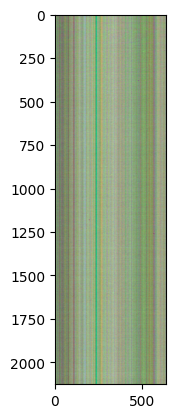

In [25]:
from scipy.ndimage import median_filter

# Load the header file
# header_file = './data/anutest/20230419/004-specim-fx10.hdr
print(header_file)
image = spectral.open_image(header_file)

# Read image data as an array
image_data = image.load()

# Normalize image data to [0, 1]
min_value = np.min(image_data)
max_value = np.max(image_data)
normalized_image_data = (image_data - min_value) / (max_value - min_value)
filtered_image_data = median_filter(normalized_image_data, size=(3, 3, 1))

# Continue working with the normalized_image_data NumPy array
wavelengths = image.metadata['wavelength']
norm_hyprgb_calib_image_file = get_hyp_rgb(filtered_image_data, wavelengths, header_file[:-4]+'-calib----')

### Denoised Hyperspectral RGB Image

In [5]:
import spectral
import numpy as np
from skimage.restoration import denoise_nl_means

# Load the header file
# header_file = './data/anutest/20230419/004-specim-fx10.hdr'
image = spectral.open_image(header_file)

# Read image data as an array
image_data = image.load()

# Prepare an empty array for the denoised image data
denoised_image_data = np.empty_like(image_data)

# Apply NL-means denoising to each band in the image
for band in range(image_data.shape[2]):
    denoised_image_data[:, :, band] = denoise_nl_means(image_data[:, :, band], fast_mode=True)

# Continue working with the denoised_image_data NumPy array
wavelengths = image.metadata['wavelength']
denoised_hyprgb_calib_image_file = get_hyp_rgb(filtered_image_data, wavelengths, header_file[:-4]+'-calib----')

ValueError: could not broadcast input array from shape (2127,640) into shape (2127,640,1)

## Test for Noise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def analyze_hyperspectral_noise(image_data, wavelengths, region_coords=None):
    """
    Analyze noise in a hyperspectral cube.
    
    Parameters:
        image_data (np.ndarray): Hyperspectral cube (H x W x Bands)
        wavelengths (list or np.ndarray): Wavelengths for each band
        region_coords (tuple): Optional (x1, y1, x2, y2) for uniform region
    """

    # Pick a uniform region for analysis (or center patch)
    h, w, b = image_data.shape
    if region_coords:
        x1, y1, x2, y2 = region_coords
    else:
        x1, y1, x2, y2 = w//2 - 10, h//2 - 10, w//2 + 10, h//2 + 10

    region = image_data[y1:y2, x1:x2, :]
    mean_signal = np.mean(region, axis=(0,1))
    std_noise = np.std(region, axis=(0,1))
    snr = mean_signal / (std_noise + 1e-8)

    # Plot reflectance curve
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(wavelengths, mean_signal, color='blue')
    plt.title("Reflectance Curve (Smoothness Check)")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Mean Reflectance")

    # Plot SNR across wavelengths
    plt.subplot(1,3,2)
    plt.plot(wavelengths, snr, color='green')
    plt.title("Signal-to-Noise Ratio (SNR) per Band")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("SNR")
    plt.axhline(20, color='red', linestyle='--', label='Low SNR threshold')
    plt.legend()

    # Band-to-band correlation
    correlations = [pearsonr(image_data[:,:,i].flatten(), image_data[:,:,i+1].flatten())[0]
                    for i in range(b-1)]
    plt.subplot(1,3,3)
    plt.plot(wavelengths[:-1], correlations, color='purple')
    plt.title("Band-to-Band Correlation")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Correlation Coefficient")

    plt.tight_layout()
    plt.show()

    avg_snr = np.mean(snr)
    print(f"Average SNR: {avg_snr:.2f}")
    if avg_snr < 20:
        print("Warning: Image appears noisy (low SNR).")
    else:
        print("Image quality seems good (high SNR).")

    return {
        "mean_reflectance": mean_signal,
        "snr": snr,
        "correlations": correlations,
        "avg_snr": avg_snr
    }

In [ ]:
image = spectral.open_image(header_file)
image_data = image.load()
wavelengths = image.metadata['wavelength']

result = analyze_hyperspectral_noise(image_data,wavelengths)